<a href="https://colab.research.google.com/github/AlfredoPoblete/TecProcesHabla/blob/main/003_Trabajo_N%C2%BA3_Integrador_Text_Mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Integrador Text Mining

Este notebook aplicaremos minería de texto al contenido de críticas de películas extraído de un sitio web. El análisis se centrará en las películas mejor valoradas por los usuarios más influyentes, con el fin de descubrir información relevante, patrones o relaciones ocultas en los datos textuales.

## 1 - Importamos Librerias Necesarias

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re
import string
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
import nltk
from nltk.corpus import stopwords, PlaintextCorpusReader
from collections import Counter
import os
import pickle
from google.colab import drive

Descripcion de Librerias:

* requests: Se utiliza para realizar peticiones HTTP a servidores web, como descargar el contenido HTML de una página.

* BeautifulSoup: Biblioteca para analizar documentos HTML y XML. Permite navegar y buscar elementos específicos dentro de la estructura del documento de forma sencilla.

* pandas: Proporciona estructuras de datos de alto rendimiento y fáciles de usar, como DataFrames, que son ideales para manipular y analizar datos tabulares (como los que se pueden extraer de una web).

* re: Módulo para trabajar con expresiones regulares, que son patrones de búsqueda potentes para encontrar y manipular texto dentro de cadenas.

* string: Contiene constantes útiles relacionadas con cadenas, como todos los caracteres de puntuación, letras, etc., que a menudo se utilizan para limpiar texto.

* word_tokenize: Función de la librería Natural Language Toolkit (NLTK) para dividir una cadena de texto en palabras individuales (tokens).

* CountVectorizer: De la librería scikit-learn, se utiliza para convertir una colección de documentos de texto en una matriz de conteo de tokens. Es un paso fundamental para aplicar modelos de aprendizaje automático a texto.

* nltk: La librería Natural Language Toolkit, una suite completa de herramientas para el procesamiento del lenguaje natural, incluyendo tokenización, stemming, tagging, parsing y más.

* stopwords, PlaintextCorpusReader: Módulos de NLTK. 'stopwords' proporciona una lista de palabras comunes en diferentes idiomas que suelen ser eliminadas en el análisis de texto. 'PlaintextCorpusReader' permite leer colecciones de archivos de texto sin formato como un corpus.

* Counter: Un objeto de la librería estándar de Python que facilita el conteo de elementos en una lista o cualquier iterable. Es muy útil para contar la frecuencia de las palabras.

* os: Módulo que proporciona una manera de interactuar con el sistema operativo, como crear directorios, manipular rutas de archivos, etc.

* pikle: Pickle es un módulo en Python que permite serializar y deserializar objetos de Python.


## 2 - Web Scraping

Extraemos el contenido de las primeras 3 paginas web relacionada a criticas de 10 peliculas mejor valoradas por espectadores filtrados por usuarios mas seguidos.

### a) Buscamos las paginas almacenadas en la url filtrada

In [ ]:
# Guardamos la url para luego extraer los diferentes links correspondientes a las 10 peliculas
url = "https://www.sensacine.com/peliculas/mejores-peliculas/"
response = requests.get(url)
soup = BeautifulSoup(response.content, "html.parser")
for a in soup.find_all("a", href=True, class_="meta-title-link"):
  print(a)

<a class="meta-title-link" href="/peliculas/pelicula-1628/">El padrino</a>
<a class="meta-title-link" href="/peliculas/pelicula-9393/">La lista de Schindler</a>
<a class="meta-title-link" href="/peliculas/pelicula-11736/">Cadena perpetua</a>
<a class="meta-title-link" href="/peliculas/pelicula-28201/">El Padrino. Parte II</a>
<a class="meta-title-link" href="/peliculas/pelicula-64439/">La vida es bella</a>
<a class="meta-title-link" href="/peliculas/pelicula-24944/">Gladiator (El gladiador)</a>
<a class="meta-title-link" href="/peliculas/pelicula-10568/">Forrest Gump</a>
<a class="meta-title-link" href="/peliculas/pelicula-10862/">El Rey León</a>
<a class="meta-title-link" href="/peliculas/pelicula-115362/">El caballero oscuro</a>
<a class="meta-title-link" href="/peliculas/pelicula-10126/">Pulp Fiction</a>


Observamos que cada uno de los links se encuentran incompletos, por lo cual agregamos a cada link la extensión que corresponde para poder ingresar a cada una de ellas

In [ ]:
# Iteramos para cada etiqueta para agregar las extenciones correspondientes de la pagina
for a in soup.find_all("a", href=True, class_="meta-title-link"):
  link = a['href']
  print("https://www.sensacine.com" + link + "criticas-espectadores/mas-seguidos/")

https://www.sensacine.com/peliculas/pelicula-1628/criticas-espectadores/mas-seguidos/
https://www.sensacine.com/peliculas/pelicula-9393/criticas-espectadores/mas-seguidos/
https://www.sensacine.com/peliculas/pelicula-11736/criticas-espectadores/mas-seguidos/
https://www.sensacine.com/peliculas/pelicula-28201/criticas-espectadores/mas-seguidos/
https://www.sensacine.com/peliculas/pelicula-64439/criticas-espectadores/mas-seguidos/
https://www.sensacine.com/peliculas/pelicula-24944/criticas-espectadores/mas-seguidos/
https://www.sensacine.com/peliculas/pelicula-10568/criticas-espectadores/mas-seguidos/
https://www.sensacine.com/peliculas/pelicula-10862/criticas-espectadores/mas-seguidos/
https://www.sensacine.com/peliculas/pelicula-115362/criticas-espectadores/mas-seguidos/
https://www.sensacine.com/peliculas/pelicula-10126/criticas-espectadores/mas-seguidos/


### b) Almacenamos el contenido de las primeras 3 paginas de cada uno de los links

In [ ]:
# Crea listas vacias para almacenar el titulo de cada pelicula en una lista cada una de las criticas en otra lista.
titulo = []
critica = []

# Recorre cada url para almacenar las primeras 3 url correspondientes a criticas de usuarios mas seguidos
for a in soup.find_all("a", href=True, class_="meta-title-link"):
  link = a['href']
  pag_1 = "https://www.sensacine.com" + link + "criticas-espectadores/mas-seguidos/"
  texto_1 = requests.get(pag_1)
  soup_1 = BeautifulSoup(texto_1.content, "html.parser")
  pag_2 = pag_1 + "?page=2"
  texto_2 = requests.get(pag_2)
  soup_2 = BeautifulSoup(texto_2.content, "html.parser")
  pag_3 = pag_1 + "?page=3"
  texto_3 = requests.get(pag_3)
  soup_3 = BeautifulSoup(texto_3.content, "html.parser")

  # Extrae el titulo y lo guarda en una variable para ser almacenada en la lista
  titulo.append(a.text)

  # Extrae el contenido de las 3 primeras paginas de cada pelicula
  content1 = soup_1.find_all("div", class_="content-txt review-card-content")
  content2 = soup_2.find_all("div", class_="content-txt review-card-content")
  content3 = soup_3.find_all("div", class_="content-txt review-card-content")

  # Si existe contenido en cada contenedor lo almacenamos
  content = ""
  if content1:
    content += "\n".join([c.get_text(strip=True) for c in content1])
  if content2:
    content += "\n".join([c.get_text(strip=True) for c in content2])
  if content3:
    content += "\n".join([c.get_text(strip=True) for c in content3])
  critica.append(content)


### c) Creamos un dataframe con los datos almacenados

In [ ]:
data = [titulo, critica]
df_original = pd.DataFrame(data, index=['titulo', 'critica']).transpose()
df_original.head(10)

,titulo,critica
0,El padrino,"Cine con mayúsculas, los años pasan y la hacen..."
1,La lista de Schindler,aunque la lista de schindler durá muchisimo la...
2,Cadena perpetua,"Cine de la vieja escuela, grande hasta el más ..."
3,El Padrino. Parte II,"""El Padrino. Parte II"" es una magistral secuel..."
4,La vida es bella,"IMPRESCINDIBLE PELICULA,rozando la ""obra maest..."
5,Gladiator (El gladiador),La pelicula que pasará a la historia.Peliculón...
6,Forrest Gump,Una película que logra ponerte todos tus senti...
7,El Rey León,Disney acertó de pleno en 1994 con El rey león...
8,El caballero oscuro,la interpretación de heath ledger como el joke...
9,Pulp Fiction,"Segundo largo de Quentin Tarantino, con el que..."


In [ ]:
# Guardamos el dataframe en formato pikle
drive.mount('/content/drive')

# Creamos el directorio si no existe
directory_path = '/content/drive/MyDrive/TP_Proces_Habla'
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

df_original.to_pickle('/content/drive/MyDrive/TP_Proces_Habla/df_original.pkl')


Mounted at /content/drive


## 2 - Limpieza de Datos
Para poder trabajar de manera más efectiva y extraer información significativa
limpiamos el texto de expresiones regulares

### a) Creamos una funcion para eliminar expresiones regulares del texto

In [ ]:
# Defino la funcion si el texto existe en cada registro
def limpiar_texto(text):
  if text is not None:
    text = text.lower()
    text = re.sub('\[.*?¿\]\%', ' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[‘’“”…«»]', '', text)
    text = re.sub('\n', ' ', text)
  else:
        text = ''
  return text

### b) Aplicamos la funcion a un nuevo dataframe

In [ ]:
# Primero copiamos eldataframe original y luego aplicamos la funcion
df_limpio  = df_original.copy()
df_limpio['critica'] = df_limpio['critica'].apply(limpiar_texto)
df_limpio.head()


,titulo,critica
0,El padrino,cine con mayúsculas los años pasan y la hacen...
1,La lista de Schindler,aunque la lista de schindler durá muchisimo la...
2,Cadena perpetua,cine de la vieja escuela grande hasta el más ...
3,El Padrino. Parte II,el padrino parte ii es una magistral secuel...
4,La vida es bella,imprescindible pelicula rozando la obra maest...


### c) Guardamos el dataframe

In [ ]:
# Guardamos el dataframe en formato pikle
df_limpio.to_pickle('/content/drive/MyDrive/TP_Proces_Habla/df_limpio.pkl')

In [ ]:
carpeta_destino = '/content/drive/MyDrive/TP_Proces_Habla/Criticas_por_Peliculas'

# Crea la carpeta si no existe
if not os.path.exists(carpeta_destino):
    os.makedirs(carpeta_destino)
    print(f"Carpeta '{carpeta_destino}' creada.")
else:
    print(f"La carpeta '{carpeta_destino}' ya existe.")

# Itera sobre cada fila del DataFrame
for index, row in df_limpio.iterrows():
    titulo = row['titulo']
    critica_texto = row['critica']

    # Crea un nombre de archivo seguro a partir del título
    nombre_archivo = f"{''.join(c if c.isalnum() else ' ' for c in titulo)}.txt"
    ruta_archivo = os.path.join(carpeta_destino, nombre_archivo)

    try:
        # Guarda la crítica en un archivo de texto
        with open(ruta_archivo, 'w', encoding='utf-8') as archivo:
            archivo.write(critica_texto)
        print(f"Crítica de '{titulo}' guardada en: {ruta_archivo}")
    except Exception as e:
        print(f"Error al guardar la crítica de '{titulo}': {e}")

print("Proceso de guardado completado.")

La carpeta '/content/drive/MyDrive/TP_Proces_Habla/Criticas_por_Peliculas' ya existe.
Crítica de 'El padrino' guardada en: /content/drive/MyDrive/TP_Proces_Habla/Criticas_por_Peliculas/El padrino.txt
Crítica de 'La lista de Schindler' guardada en: /content/drive/MyDrive/TP_Proces_Habla/Criticas_por_Peliculas/La lista de Schindler.txt
Crítica de 'Cadena perpetua' guardada en: /content/drive/MyDrive/TP_Proces_Habla/Criticas_por_Peliculas/Cadena perpetua.txt
Crítica de 'El Padrino. Parte II' guardada en: /content/drive/MyDrive/TP_Proces_Habla/Criticas_por_Peliculas/El Padrino  Parte II.txt
Crítica de 'La vida es bella' guardada en: /content/drive/MyDrive/TP_Proces_Habla/Criticas_por_Peliculas/La vida es bella.txt
Crítica de 'Gladiator (El gladiador)' guardada en: /content/drive/MyDrive/TP_Proces_Habla/Criticas_por_Peliculas/Gladiator  El gladiador .txt
Crítica de 'Forrest Gump' guardada en: /content/drive/MyDrive/TP_Proces_Habla/Criticas_por_Peliculas/Forrest Gump.txt
Crítica de 'El Rey L

## 3 - Creamos nuestro “Bag of Words”

Creamos una bolsa de palabras para representar una version simplificada de cada una de las criticas como vector, con el objetivo de estudiar las palabras que más frecuentes.

In [ ]:
# Descargamos stopwords en spanish
nltk.download('stopwords')
lines = nltk.corpus.stopwords.words('spanish')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Convertir una colección de documentos de texto en una matriz de términos/tokens, ignorando stop words
cv = CountVectorizer(stop_words=lines)

# Ajustamos el modelo y lo aplicamos al texto de nuestro dataframe generando una matriz dispersa
df_cv = cv.fit_transform(df_limpio['critica'])

# Guardamos el objeto CountVectorize
pickle.dump(cv, open("/content/drive/MyDrive/TP_Proces_Habla/cv.pkl", "wb"))

In [ ]:
# Convierte la matriz dispersa a una matriz densa y la estructura en un DataFrame
df_dtm = pd.DataFrame(df_cv.toarray(), columns=cv.get_feature_names_out())

# Le asignamos los indices del dataframe
df_dtm.index = df_limpio['titulo']

# Guardamos el dataframe como matriz esparsa en formato pickle
df_dtm.to_pickle('/content/drive/MyDrive/TP_Proces_Habla/df_dtm.pkl')

In [ ]:
df_dtm

,aaron,abajo,abandonado,abandonarlo,abbandando,abborido,abe,aberraciones,abierto,abismo,...,última,últimamente,últimas,último,últimos,única,únicamente,únicas,único,únicos
titulo,,,,,,,,,,,,,,,,,,,,,
El padrino,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,1,0,0,0,2,0
La lista de Schindler,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,1,0,0,0,0
Cadena perpetua,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
El Padrino. Parte II,0,3,0,0,1,0,1,0,0,0,...,1,0,0,1,0,1,0,1,1,1
La vida es bella,0,0,0,0,0,0,0,0,0,0,...,2,1,0,0,1,1,0,0,0,0
Gladiator (El gladiador),0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
Forrest Gump,0,0,1,1,0,1,0,0,0,1,...,1,0,0,0,0,3,0,0,2,0
El Rey León,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
El caballero oscuro,4,0,0,0,0,0,0,0,1,1,...,0,0,0,1,0,1,0,0,1,0


Esta representacion de texto a matriz esparsa nos permie realizar análisis más complejos, ahorrando espacio y mejorando el rendimiento en operaciones matematicas.

## 4 - Analisis Exploratorio


### a) Exploramos el dataset

In [ ]:
# Visualizamos el dataframe de manera transpuesta
dtm_transpuesta = df_dtm.transpose()
dtm_transpuesta

titulo,El padrino,La lista de Schindler,Cadena perpetua,El Padrino. Parte II,La vida es bella,Gladiator (El gladiador),Forrest Gump,El Rey León,El caballero oscuro,Pulp Fiction
aaron,0,0,0,0,0,0,0,0,4,0
abajo,0,0,0,3,0,0,0,0,0,0
abandonado,0,0,0,0,0,0,1,0,0,0
abandonarlo,0,0,0,0,0,0,1,0,0,0
abbandando,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
única,0,1,0,1,1,0,3,0,1,0
únicamente,0,0,0,0,0,0,0,0,0,1
únicas,0,0,0,1,0,0,0,0,0,0
único,2,0,2,1,0,1,2,0,1,1


### b) Palabras mas usadas por pelicula

In [ ]:
# Iteramos en cada registro
for index, row in df_limpio.iterrows():
    titulo = row['titulo']
    critica = row['critica']

    # Transformar cada texto en un vector de conteo
    X = cv.fit_transform([critica])  # Transform the single review

    # Obtiene la palabra y su frecuencia en cada una de las criticas
    words = cv.get_feature_names_out()
    frequencias = X.toarray().sum(axis=0)

    # Crea un diccionario y ordena las palafras con mayor frecuencia
    word_freq = dict(zip(words, frequencias))
    frecuencia_ordenada = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

    # Muestra el titulo de la pelicula con las precuencias de cada palabra
    print(f"'{titulo}': {[(word, freq.item()) for word, freq in frecuencia_ordenada]}")

'El padrino': [('película', 35), ('coppola', 33), ('corleone', 24), ('the', 23), ('brando', 22), ('michael', 22), ('historia', 20), ('pacino', 18), ('cine', 17), ('mejor', 17), ('marlon', 15), ('películas', 15), ('vito', 15), ('mafia', 13), ('mejores', 13), ('paramount', 13), ('guión', 12), ('actor', 11), ('godfather', 11), ('padrino', 11), ('parte', 11), ('puzo', 11), ('crimen', 10), ('director', 10), ('film', 10), ('obra', 10), ('familia', 9), ('francis', 9), ('maestra', 9), ('don', 8), ('ford', 8), ('novela', 8), ('nueva', 8), ('robert', 8), ('us', 8), ('bien', 7), ('carlo', 7), ('connie', 7), ('familias', 7), ('hijo', 7), ('mientras', 7), ('millones', 7), ('papel', 7), ('personaje', 7), ('york', 7), ('después', 6), ('dos', 6), ('ejemplo', 6), ('escenas', 6), ('guerra', 6), ('hacen', 6), ('música', 6), ('organizado', 6), ('perfecta', 6), ('sonny', 6), ('actores', 5), ('cosa', 5), ('dirección', 5), ('duvall', 5), ('ejecutivos', 5), ('escena', 5), ('estadounidense', 5), ('familiar', 5

In [ ]:
# Creo un diccionario
top_dict = {}

# Itera por cada filas y muestro en forma decreciente las 30 palabras mas usadas por pelicula
for c in dtm_transpuesta.columns:
    top = dtm_transpuesta[c].sort_values(ascending=False).head(30) #
    top_dict[c]= list(zip(top.index, top.values))

print(top_dict)
print("\n")

# Imprimo las 15 palabras mas frecuentes por pelicula
for titulo, top_words in top_dict.items():
    print(titulo)
    print(', '.join([str(word) for word, count in top_words[0:14]]))

{'El padrino': [('película', np.int64(35)), ('coppola', np.int64(33)), ('corleone', np.int64(24)), ('the', np.int64(23)), ('brando', np.int64(22)), ('michael', np.int64(22)), ('historia', np.int64(20)), ('pacino', np.int64(18)), ('mejor', np.int64(17)), ('cine', np.int64(17)), ('marlon', np.int64(15)), ('películas', np.int64(15)), ('vito', np.int64(15)), ('mejores', np.int64(13)), ('mafia', np.int64(13)), ('paramount', np.int64(13)), ('guión', np.int64(12)), ('actor', np.int64(11)), ('godfather', np.int64(11)), ('puzo', np.int64(11)), ('padrino', np.int64(11)), ('parte', np.int64(11)), ('crimen', np.int64(10)), ('film', np.int64(10)), ('obra', np.int64(10)), ('director', np.int64(10)), ('maestra', np.int64(9)), ('familia', np.int64(9)), ('francis', np.int64(9)), ('robert', np.int64(8))], 'La lista de Schindler': [('película', np.int64(20)), ('schindler', np.int64(19)), ('spielberg', np.int64(15)), ('películas', np.int64(11)), ('obra', np.int64(10)), ('vida', np.int64(10)), ('liam', np.

Notamos que entre las palabras mas usadas en cada critica, se encuentran aquellas que no nos aporta informacion importante, lo cual trataremos a continuacion

### c) Agregamos palabras redundantes a stopwords



In [ ]:
# Armo una lista con cada palabra
words = []
for titulo in dtm_transpuesta.columns:
    top = [word for (word, count) in top_dict[titulo]]
    for t in top:
        words.append(t)

# Con .most_common() obtengo las palabras mas usadas, y la cantidad de veces que fue agregada a la lista words
print(Counter(words).most_common())

# Creo una lista de nuevas stop words
add_stop_words = [word for word, count in Counter(words).most_common() if count > 5]
print(add_stop_words)

[('película', 10), ('historia', 10), ('mejor', 8), ('películas', 8), ('obra', 8), ('mejores', 7), ('maestra', 7), ('cine', 6), ('hace', 6), ('vida', 5), ('gran', 5), ('ser', 5), ('pelicula', 5), ('guión', 4), ('ver', 4), ('bien', 4), ('the', 3), ('director', 3), ('vez', 3), ('si', 3), ('coppola', 2), ('corleone', 2), ('michael', 2), ('pacino', 2), ('vito', 2), ('godfather', 2), ('padrino', 2), ('parte', 2), ('film', 2), ('familia', 2), ('francis', 2), ('robert', 2), ('guerra', 2), ('cinta', 2), ('va', 2), ('personaje', 2), ('dos', 2), ('personajes', 2), ('visto', 2), ('años', 2), ('hacer', 2), ('tan', 2), ('buena', 2), ('banda', 2), ('escenas', 2), ('mundo', 2), ('brando', 1), ('marlon', 1), ('mafia', 1), ('paramount', 1), ('actor', 1), ('puzo', 1), ('crimen', 1), ('schindler', 1), ('spielberg', 1), ('liam', 1), ('judíos', 1), ('fiennes', 1), ('neeson', 1), ('ralph', 1), ('nazi', 1), ('holocausto', 1), ('lista', 1), ('blanco', 1), ('empresario', 1), ('forma', 1), ('mundial', 1), ('imag

In [ ]:
# Agregamos la lista de stop words "lines" las nuevas stop words
for pal in add_stop_words:
    lines.append(pal)

# Creamos la lista que tiene algunos nombres propios que aparecieron entre las palabras mas frecuentes y otro tipo de palabras
more_stop_words=['aser','forrest','gump','hace','dos','pulp','primera','secuela','fiction','pacino','ver','the','vez','si','parte','film','va','hacer','veces', 'así', 'luego', 'quizá','cosa','cosas','tan','asi','disney','todas','sólo','corleone','spoiler','schindler','aaron','pelicula','padrino','rey','león']
for pal in more_stop_words:
    lines.append(pal)

# Recreamos la matriz de documentos y terminos pero ustando la nueva lista "mejorada" de stopwords
cv = CountVectorizer(stop_words=lines)
data_cv = cv.fit_transform(df_limpio['critica'])
# Use get_feature_names_out() instead of get_feature_names()
data_stop = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names_out())
data_stop.index = df_limpio.index

In [ ]:
data_stop

,abajo,abandonado,abandonarlo,abbandando,abborido,abe,aberraciones,abierto,abismo,abocaría,...,última,últimamente,últimas,último,últimos,única,únicamente,únicas,único,únicos
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,1,0,0,0,2,0
1,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
3,3,0,0,1,0,1,0,0,0,1,...,1,0,0,1,0,1,0,1,1,1
4,0,0,0,0,0,0,0,0,0,0,...,2,1,0,0,1,1,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
6,0,1,1,0,1,0,0,0,1,0,...,1,0,0,0,0,3,0,0,2,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,1,1,0,...,0,0,0,1,0,1,0,0,1,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,1,1


De esta manera obtenemos una matriz reducida de palabras innecesarias

## 5 - Nubes de palabras

Creamos una nube de palabras por cada pelicula

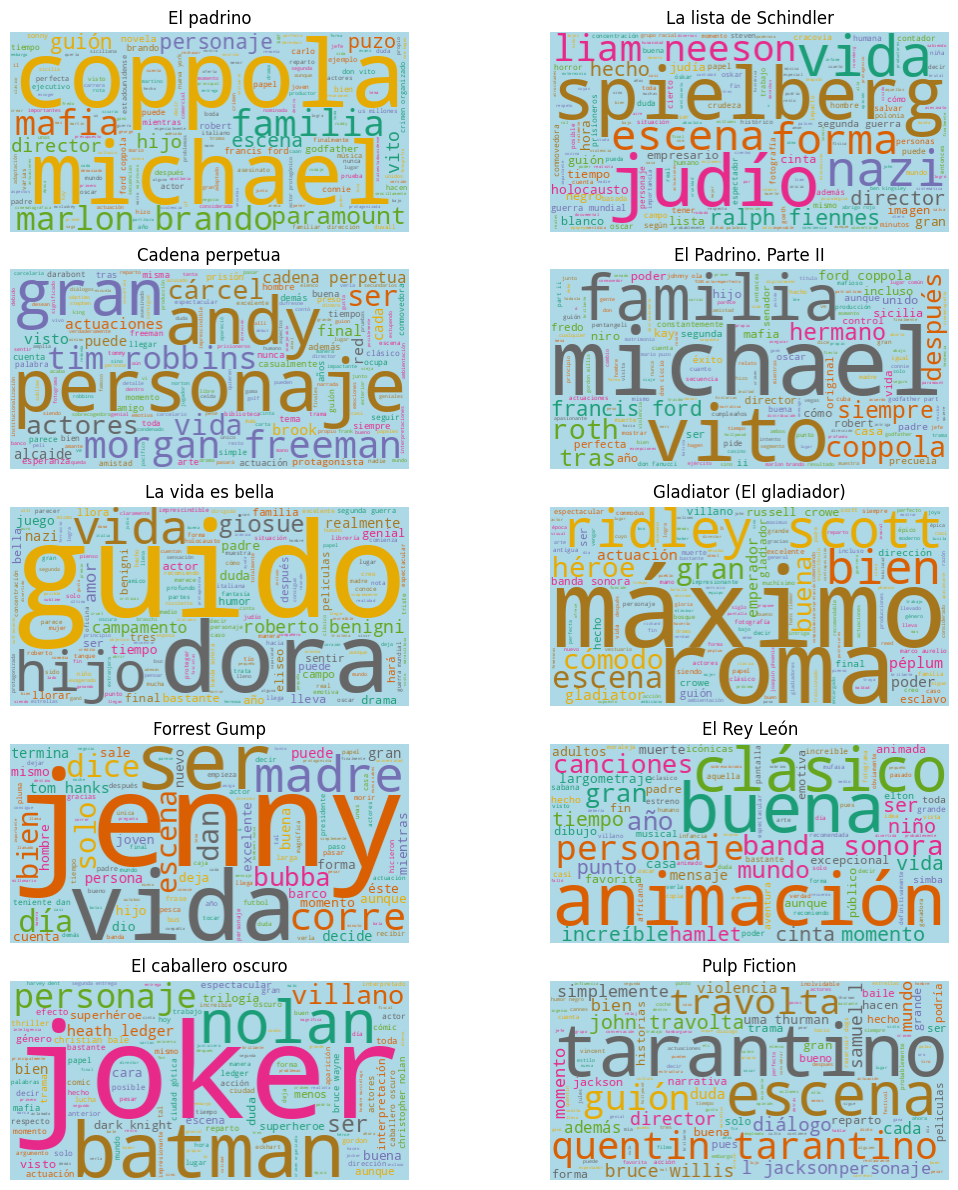

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Configure plot size
plt.rcParams['figure.figsize'] = [12, 18]

# Create WordCloud object
wordcloud = WordCloud(
    stopwords=lines,
    background_color="lightblue",
    colormap="Dark2",
    max_font_size=150,
    random_state=42
)

# Generate and display word clouds for each movie title
num_plots = len(df_limpio['titulo'])
num_rows = 5
num_cols = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))  # Create subplots with specified size

for index, (titulo, critica) in enumerate(zip(df_limpio['titulo'], df_limpio['critica'])):
    # Only plot if within the subplot grid
    if index < num_rows * num_cols:
        # Calculate subplot row and column index
        row_index = index // num_cols
        col_index = index % num_cols

        # Generate word cloud
        wordcloud.generate(critica)

        # Display word cloud in the corresponding subplot
        axes[row_index, col_index].imshow(wordcloud, interpolation="bilinear")
        axes[row_index, col_index].axis("off")
        axes[row_index, col_index].set_title(titulo)

plt.tight_layout()  # Adjust subplot parameters for a tight layout
plt.show()

Con estos graficos podemos sacar diferentes conclusiones:

*  La presencia de actores o personajes memorables
*  Se comenta mas el tema de la familia en El padrino 2 que en la 1
*  La animacion de la pelicula el Rey Leon es muy significativa
*  Se habla mas del villano, que del heroe en la pelicula de Batman

### 6 - Frecuencia de Palabras Clave en Críticas de Películas (Por Aspecto)

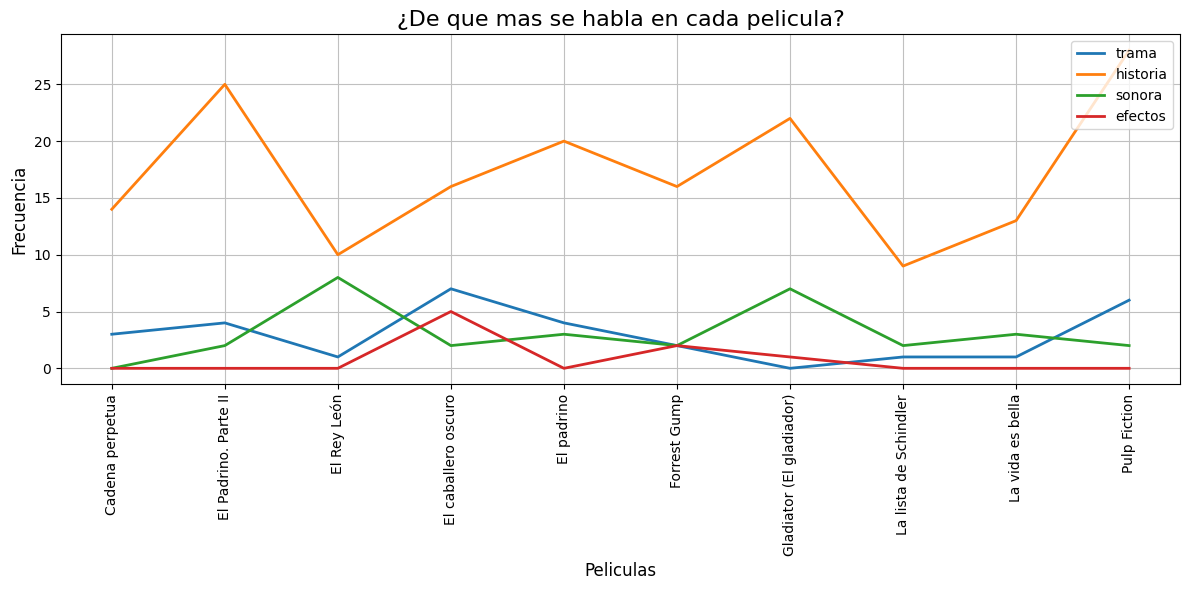

In [ ]:
corpus_root = '/content/drive/MyDrive/TP_Proces_Habla/Criticas_por_Peliculas'
wordlists = PlaintextCorpusReader(corpus_root, '.*', encoding='latin-1')
#wordlists.fileids() # con esto listamos los archivos del directorio

plt.rcParams['figure.figsize'] = [12, 6]
cfd = nltk.ConditionalFreqDist(
        (word,genre)
        for genre in df_limpio['titulo']
        for w in wordlists.words(''.join(c if c.isalnum() else ' ' for c in genre) + '.txt')  # Fix: Use the same file naming logic
        for word in ['historia','efectos','trama','sonora']
        if w.lower().startswith(word) )
cfd.plot()

# Agregar título a la imagen
plt.title('¿De que mas se habla en cada pelicula?', fontsize=16)

# Obtener el objeto AxesSubplot para configurar los nombres de los ejes
ax = plt.gca()

# Nombre del eje x (condiciones)
ax.set_xlabel('Peliculas', fontsize=12)

# Nombre del eje y (frecuencia)
ax.set_ylabel('Frecuencia', fontsize=12)

plt.tight_layout() # Ajusta el layout para evitar que las etiquetas se superpongan
plt.show()

Queda mas que claro que se habla mas de la historia de la pelicula y como segundo la banda sonora

## 7 - Creamos un nuevo Dataframe

En este apartado crearemos un nuevo dataframe con valores numericos para descubrir informacion importante

### a) Creamos una columna que representa el numero de palabras unicas por cada pelicula

In [ ]:
# Encontraremos las palabras unicas por peliculas identificando los elementos non-zero en la matriz de documentos y terminos
data = df_dtm.transpose().copy()
unique_list = []
for titulo in data.columns:
    uniques = data[titulo].to_numpy().nonzero()[0].size # tengo que transformar a un array para aplicar la funcion nonzero
    unique_list.append(uniques)

# Creo un nuevo dataframe con el numero de palabras unicas por pelicula
data_words = pd.DataFrame(list(zip(df_limpio['titulo'], unique_list)), columns=['Pelicula', 'Palabras Unicas'])
data_unique_sort = data_words.sort_values(by='Palabras Unicas', ascending=False)
print("Top criticas de peliculas con mas palabras unicas.\n")
print(data_unique_sort)

Top criticas de peliculas con mas palabras unicas.

                   Pelicula  Palabras Unicas
0                El padrino             1438
3      El Padrino. Parte II             1289
8       El caballero oscuro             1170
9              Pulp Fiction             1139
6              Forrest Gump              971
5  Gladiator (El gladiador)              937
1     La lista de Schindler              891
4          La vida es bella              795
2           Cadena perpetua              745
7               El Rey León              471


### b) Web Scraping

Extraemos valores numericos de la pagina web como el puntaje de cada pelicula y el numero de notas para añadirla al nuevo dataset

In [ ]:
num_criticas = []
puntaje_usuarios = []
num_notas = []
puntaje_medios = []
# Suponiendo que 'soup' es el objeto BeautifulSoup con el contenido de la página principal
for a in soup.find_all("a", href=True, class_="meta-title-link"):
    link = a['href']
    link_medio = "https://www.sensacine.com" + link
    texto_medio = requests.get(link_medio)
    bsoup_medio = BeautifulSoup(texto_medio.content, "html.parser")
    puntaje_medio = bsoup_medio.find("span", class_="stareval-note")
    if puntaje_medio:
      puntaje_medios.append(puntaje_medio.get_text())
    link_title = "https://www.sensacine.com" + link + "criticas-espectadores/mas-seguidos/"
    texto_title = requests.get(link_title)
    bsoup_critic = BeautifulSoup(texto_title.content, "html.parser")
    score = bsoup_critic.find("span", class_="note")
    n_note = bsoup_critic.find("span", class_="user-note-count")
    n_critic = bsoup_critic.find("h2", class_="titlebar-title titlebar-title-md")
    if n_critic:
      n_criticas = int(n_critic.get_text().split()[0])
      num_criticas.append(n_criticas)
    if score:
      puntaje_usuarios.append(score.get_text())
    if n_note:
      num_nota = int(n_note.get_text().split()[0])
      num_notas.append(num_nota)



In [ ]:
#Agrego las columnas al dataframe
df_num = data_words.copy()
df_num['N° Criticas'] = num_criticas
df_num['N° Notas'] = num_notas
df_num['Puntaje Usuarios'] = pd.to_numeric(pd.Series(puntaje_usuarios).str.replace(',', '.'))
df_num['Puntaje Medios'] = pd.to_numeric(pd.Series(puntaje_medios).str.replace(',', '.'))

df_num

,Pelicula,Palabras Unicas,N° Criticas,N° Notas,Puntaje Usuarios,Puntaje Medios
0,El padrino,1438,89,5262,4.7,4.8
1,La lista de Schindler,891,44,4173,4.6,4.5
2,Cadena perpetua,745,32,3633,4.6,4.3
3,El Padrino. Parte II,1289,27,2876,4.6,3.9
4,La vida es bella,795,42,4529,4.6,4.2
5,Gladiator (El gladiador),937,38,5676,4.6,3.9
6,Forrest Gump,971,38,6321,4.6,4.1
7,El Rey León,471,55,6149,4.6,4.5
8,El caballero oscuro,1170,91,5346,4.6,5.0
9,Pulp Fiction,1139,57,3809,4.5,4.6


### c) Graficamos la frecuencia de cada variable

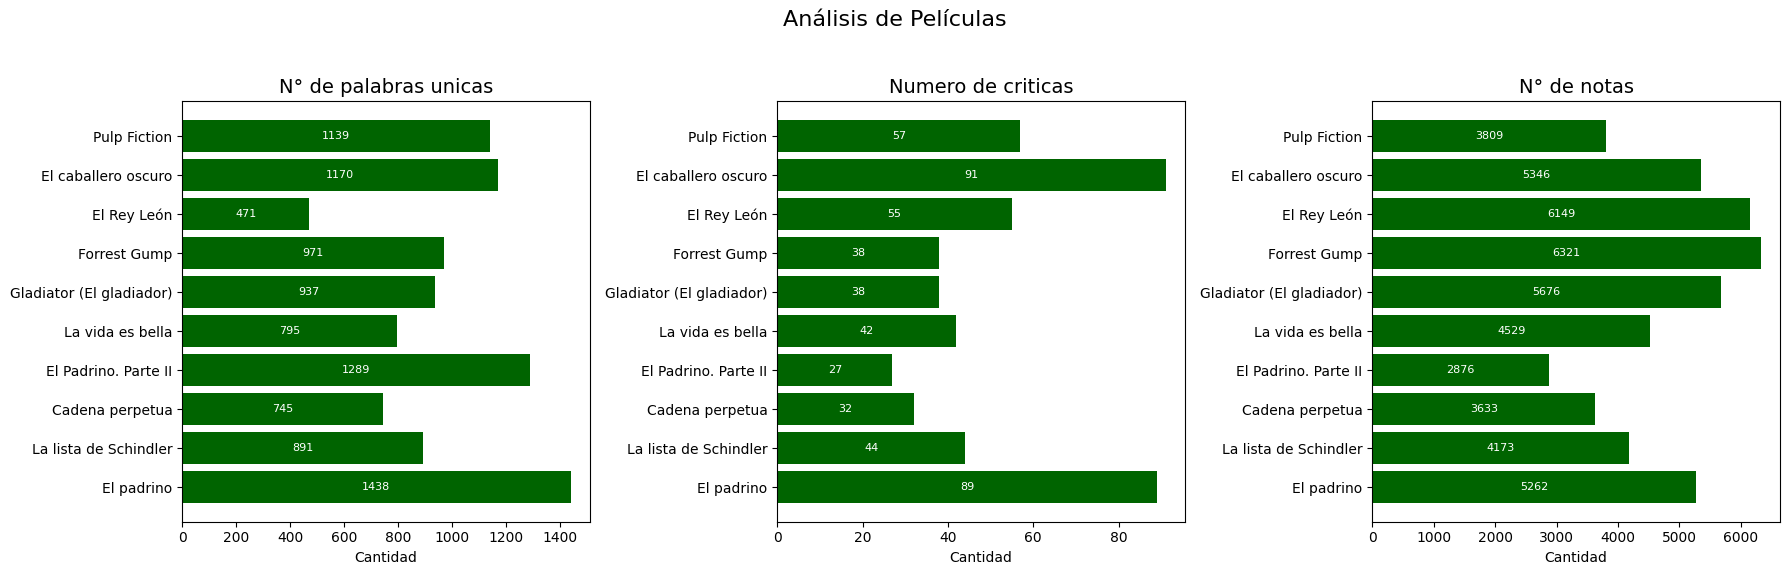

In [ ]:
plt.rcParams['figure.figsize'] = [18, 6]
fig = plt.figure()  # Creamos la figura para el título general

y_pos = np.arange(len(df_num))

# Subplot 1: Número de palabras únicas
ax1 = fig.add_subplot(1, 3, 1)
bars1 = ax1.barh(y_pos, df_num['Palabras Unicas'], align='center', color='darkgreen')
ax1.set_yticks(y_pos)
ax1.set_yticklabels(df_num['Pelicula'])
ax1.set_title('N° de palabras unicas', fontsize=14)
ax1.set_xlabel('Cantidad')  # Nombre del eje x para el primer gráfico
for bar in bars1:
    width = bar.get_width()
    ax1.annotate(f'{width}', xy=(width / 2, bar.get_y() + bar.get_height() / 2),
                ha='center', va='center', color='white', fontsize=8) # Centrar y cambiar color

# Subplot 2: Número de críticas
ax2 = fig.add_subplot(1, 3, 2)
bars2 = ax2.barh(y_pos, df_num['N° Criticas'], align='center', color='darkgreen')
ax2.set_yticks(y_pos)
ax2.set_yticklabels(df_num['Pelicula'])
ax2.set_title('Numero de criticas', fontsize=14)
ax2.set_xlabel('Cantidad')  # Nombre del eje x para el segundo gráfico
for bar in bars2:
    width = bar.get_width()
    ax2.annotate(f'{width}', xy=(width / 2, bar.get_y() + bar.get_height() / 2),
               ha='center', va='center', color='white', fontsize=8) # Centrar y cambiar color

# Subplot 3: Número de notas
ax3 = fig.add_subplot(1, 3, 3)
bars3 = ax3.barh(y_pos, df_num['N° Notas'], align='center', color='darkgreen')
ax3.set_yticks(y_pos)
ax3.set_yticklabels(df_num['Pelicula'])
ax3.set_title('N° de notas', fontsize=14)
ax3.set_xlabel('Cantidad')  # Nombre del eje x para el tercer gráfico
for bar in bars3:
    width = bar.get_width()
    ax3.annotate(f'{width}', xy=(width / 2, bar.get_y() + bar.get_height() / 2),
                ha='center', va='center', color='white', fontsize=8) # Centrar y cambiar color

fig.suptitle('Análisis de Películas', fontsize=16)  # Título para los tres gráficos
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajusta el layout para que no se superponga el título principal
plt.show()

Gracias a este grafico concluimos lo siguiente:
* Aunque la pelicula de El padrino 2 tiene menor numero de criticas, obtiene el segundo lugar en el top de numero de palabras unicas
* Las peliculas: Batman el caballero oscuro y El padrino, son las peliculas que aproximadamente tienen mayor frecuencia de cada una de las variables

### d) Grafico de Puntaje por pelicula

In [ ]:
df_num[['Pelicula','Puntaje Usuarios', 'Puntaje Medios']]

,Pelicula,Puntaje Usuarios,Puntaje Medios
0,El padrino,4.7,4.8
1,La lista de Schindler,4.6,4.5
2,Cadena perpetua,4.6,4.3
3,El Padrino. Parte II,4.6,3.9
4,La vida es bella,4.6,4.2
5,Gladiator (El gladiador),4.6,3.9
6,Forrest Gump,4.6,4.1
7,El Rey León,4.6,4.5
8,El caballero oscuro,4.6,5.0
9,Pulp Fiction,4.5,4.6


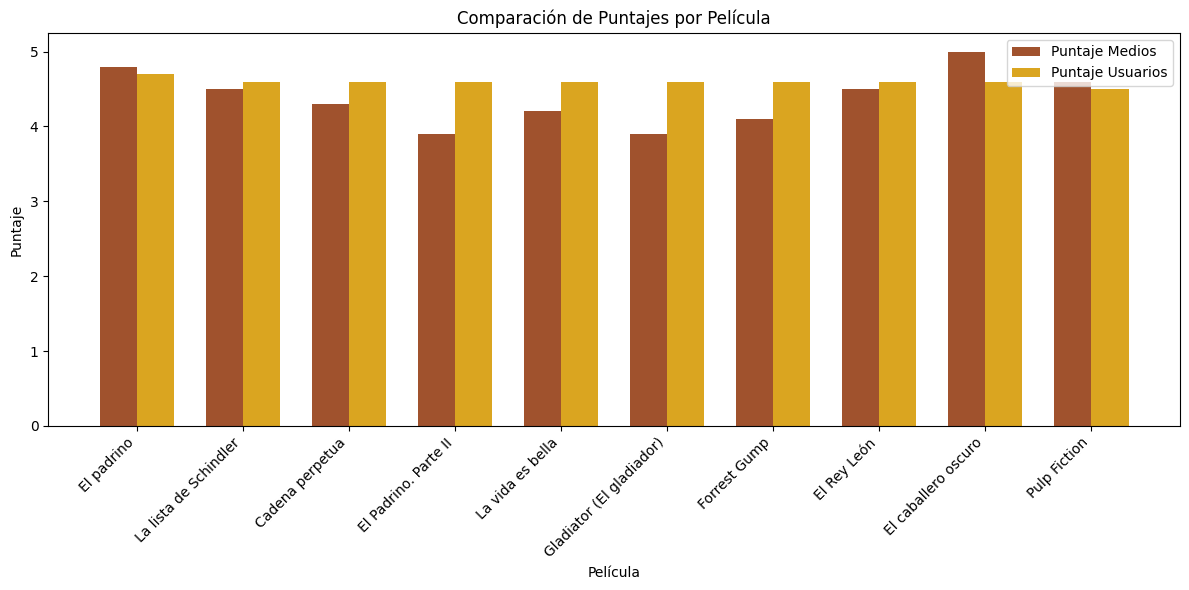

In [ ]:
# Ancho de las barras
ancho = 0.35
x = np.arange(len(df_num['Pelicula']))

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - ancho/2, df_num['Puntaje Medios'], ancho, label='Puntaje Medios', color='sienna')
rects2 = ax.bar(x + ancho/2, df_num['Puntaje Usuarios'], ancho, label='Puntaje Usuarios', color='goldenrod')

# Etiquetas y títulos
ax.set_ylabel('Puntaje')
ax.set_xlabel('Película')
ax.set_title('Comparación de Puntajes por Película')
ax.set_xticks(x)
ax.set_xticklabels(df_num['Pelicula'], rotation=45, ha='right')
ax.legend()

fig.tight_layout()
plt.show()

Analizando el grafico notamos:
* En 7 de las 10 peliculas el puntaje de usuarios es mayor al de los medios especializados
* La pelicula con mayor puntaje es de 'Batman el caballero de la noche' segun Medios y segun usuarios 'El Padrino'
* La pelicula con menor puntaje es de 'El gladiador' segun Medios y segun usuarios 'Pulp Fiction'